In [302]:
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
import category_encoders as ce
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm

In [384]:
# Find and load the dataset
for dirname, _, filenames in os.walk('C:/Users/AVCI/Desktop/CODE/Github/Bank-Marketing-Campaigns'):
    for filename in filenames:
        if filename == "bank-additional-full.csv":
            data_path = os.path.join(dirname, filename)

data = pd.read_csv(data_path, sep=';')
data.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [304]:
display('There is {} observations with {} features'.format(data.shape[0], data.shape[1]))

'There is 41188 observations with 21 features'

In [305]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [306]:
job = data['marital'].unique()
job

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [307]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week','poutcome','y']

for column in categorical_columns:
    data[column] =data[column].astype('category')

data.dtypes


age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
y                 category
dtype: object

In [308]:
numerical_column = ['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
for column in numerical_column:
    data[column] = data[column].astype(float)
data.dtypes

age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
duration           float64
campaign           float64
pdays              float64
previous           float64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
y                 category
dtype: object

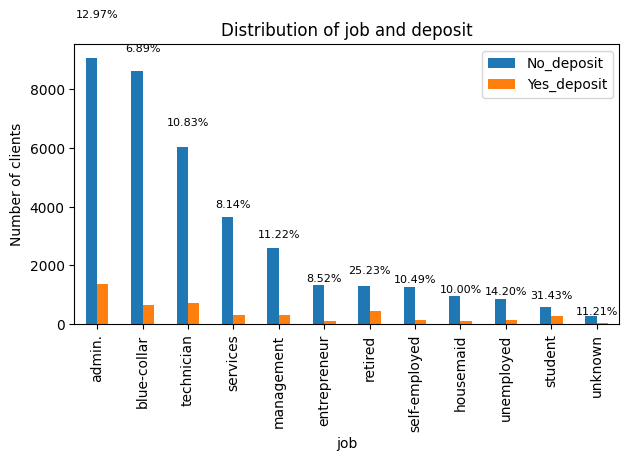

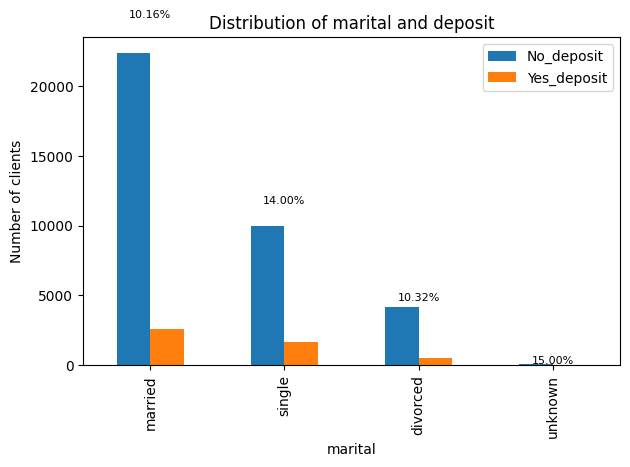

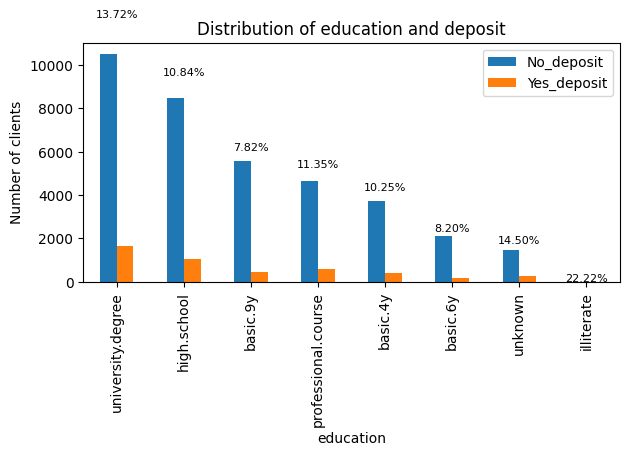

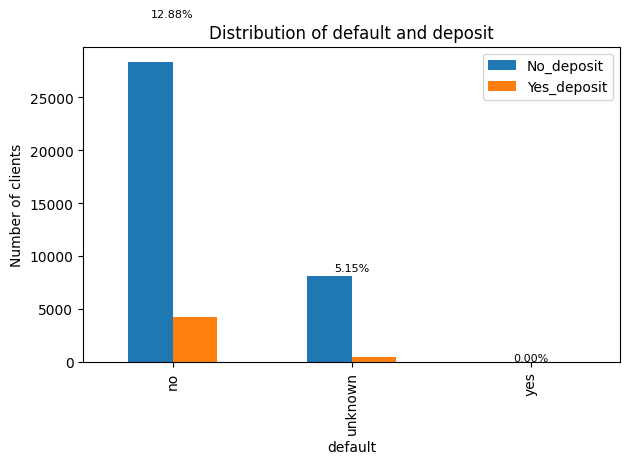

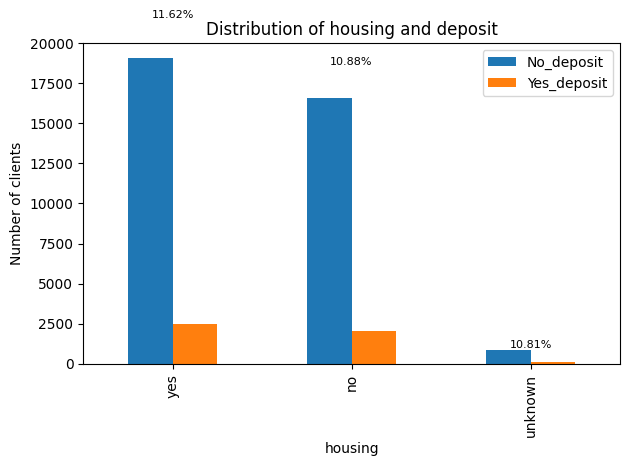

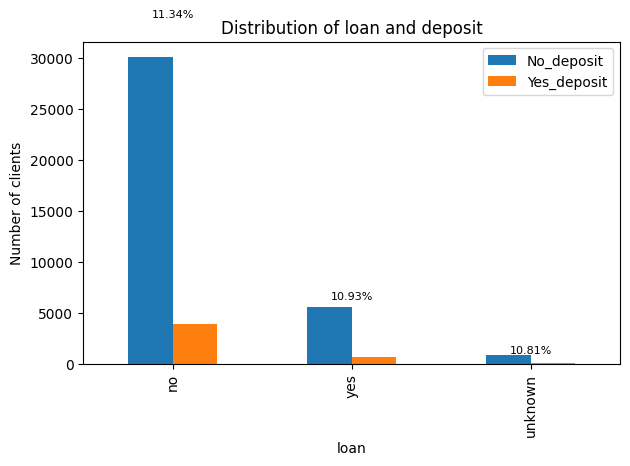

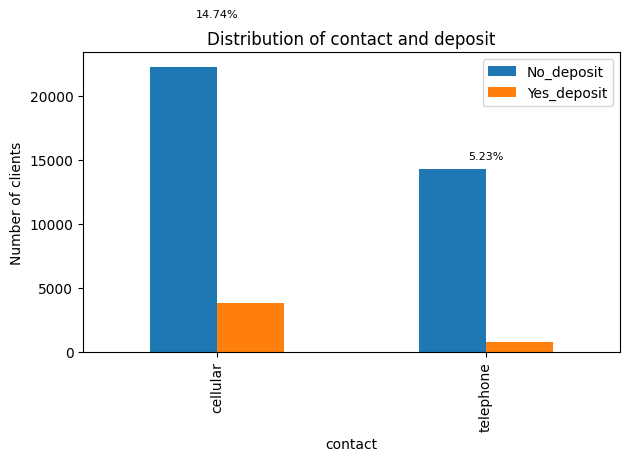

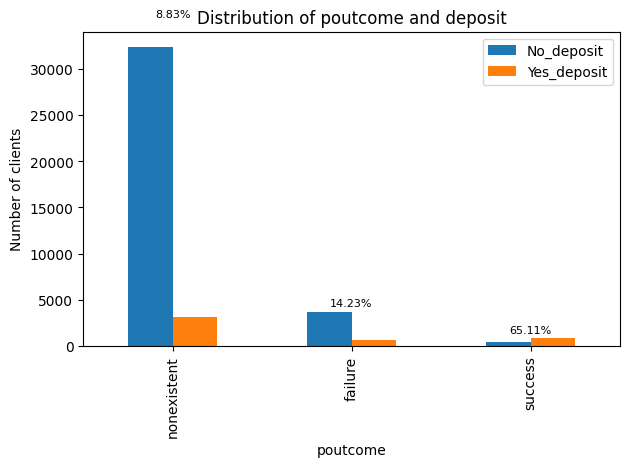

Notice: Percentage of clients who opened a term deposit


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [309]:
def show_categorical_view(column):
    # temp df 
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['No_deposit'] = data[data['y'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = data[data['y'] == 'yes'][column].value_counts()
    temp_1.plot(kind='bar')
    total_counts = temp_1['No_deposit'] + temp_1['Yes_deposit']
    no_deposit_percent = temp_1['No_deposit'] / total_counts * 100
    yes_deposit_percent = temp_1['Yes_deposit'] / total_counts * 100
    plt.xlabel(f'{column}')
    plt.ylabel('Number of clients')
    plt.title('Distribution of {} and deposit'.format(column))
    for i, value in enumerate(total_counts):
        plt.text(i, value + 10, '{:.2f}%'.format(yes_deposit_percent[i]), ha='center', fontsize=8)
    plt.tight_layout()
    plt.show();
show_categorical_view('job'), show_categorical_view('marital'),  show_categorical_view('education'), 
show_categorical_view("default"), show_categorical_view('housing'), show_categorical_view('loan'), 
show_categorical_view('contact'), show_categorical_view('poutcome')
print("Notice: Percentage of clients who opened a term deposit")
data.head()

In [310]:
data.y = data.y.map({'no':0, 'yes':1}).astype('uint8')

In [311]:
num=data.select_dtypes(include=["float64","int64"])
corr = num.corr()
corr.style.background_gradient(cmap='Reds')



,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [312]:
data.contact = data.contact.map({'cellular': 1, 'telephone': 0}).astype('uint8') 
data.loan = data.loan.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.housing = data.housing.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.default = data.default.map({'unknown':0,'yes':0,'no':1}).astype('uint8')
data.pdays = data.pdays.replace(999, 0) # replace with 0 if not contact 
data.poutcome = data.poutcome.map({'nonexistent':0, 'failure':0, 'success':1}).astype('uint8') 


In [313]:
data['cons.conf.idx'].unique()

array([-36.4, -41.8, -42.7, -36.1, -40.4, -42. , -45.9, -50. , -47.1,
       -46.2, -40.8, -33.6, -31.4, -29.8, -26.9, -30.1, -33. , -34.8,
       -34.6, -40. , -39.8, -40.3, -38.3, -37.5, -49.5, -50.8])

In [314]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['nr.employed'] = scaler.fit_transform(data['nr.employed'].values.reshape(-1, 1))
data['cons.price.idx'] = scaler.fit_transform(data['cons.price.idx'].values.reshape(-1, 1))
data['cons.conf.idx'] = scaler.fit_transform(data['cons.conf.idx'].values.reshape(-1, 1))
data['euribor3m'] = scaler.fit_transform(data['euribor3m'].values.reshape(-1, 1))
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,1,0,0,0,may,mon,...,1.0,0.0,0.0,0,1.1,0.698753,0.60251,0.957379,0.859735,0
1,57,services,married,high.school,0,0,0,0,may,mon,...,1.0,0.0,0.0,0,1.1,0.698753,0.60251,0.957379,0.859735,0
2,37,services,married,high.school,1,1,0,0,may,mon,...,1.0,0.0,0.0,0,1.1,0.698753,0.60251,0.957379,0.859735,0
3,40,admin.,married,basic.6y,1,0,0,0,may,mon,...,1.0,0.0,0.0,0,1.1,0.698753,0.60251,0.957379,0.859735,0
4,56,services,married,high.school,1,0,1,0,may,mon,...,1.0,0.0,0.0,0,1.1,0.698753,0.60251,0.957379,0.859735,0


In [315]:
def OneHatEncode(data, col):
    return pd.concat([data, pd.get_dummies(col, prefix=col.name)], axis=1)

data = OneHatEncode(data,data.job)
data = OneHatEncode(data,data.month)
data = OneHatEncode(data, data.day_of_week)
data.drop(['job', 'month', 'day_of_week'], axis=1, inplace=True)

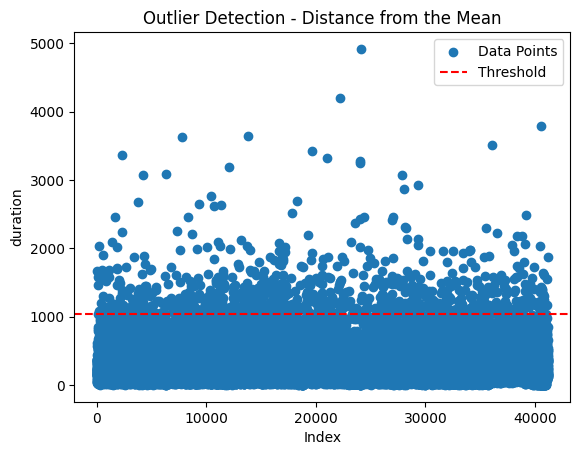

In [316]:
column = 'duration'
values = data[column].values

mean = np.mean(values)
std = np.std(values)

threshold = mean + 3 * std
outliers = values[values > threshold]

plt.scatter(range(len(values)), values, label='Data Points')
plt.xlabel('Index')
plt.ylabel(column)
plt.title('Outlier Detection - Distance from the Mean')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [317]:
def duration(data):
    data.loc[data['duration'] <= threshold/4, 'duration'] = 1
    data.loc[(data['duration'] > threshold/4) & (data['duration'] <= threshold/4*2)  , 'duration'] = 2
    data.loc[(data['duration'] > threshold/4*2) & (data['duration'] <= threshold/2*3)  , 'duration'] = 3
    data.loc[(data['duration'] > threshold/4*3) & (data['duration'] <= threshold), 'duration'] = 4
    data.loc[data['duration']  > threshold, 'duration'] = 5
    return data
duration(data);
data.head()

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,married,basic.4y,1,0,0,0,2.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
1,57,married,high.school,0,0,0,0,1.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
2,37,married,high.school,1,1,0,0,1.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
3,40,married,basic.6y,1,0,0,0,1.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
4,56,married,high.school,1,0,1,0,2.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False


In [318]:
''' Target encoding for two categorical feature '''
# save target variable before transformation
y = data.y
# Create target encoder object and transoform two value
target_encode = ce.target_encoder.TargetEncoder(cols=['marital', 'education']).fit(data, y)
numeric_dataset = target_encode.transform(data)
# drop target variable
numeric_dataset.drop('y', axis=1, inplace=True)
'''Check numerical data set'''
display(numeric_dataset.head(3), numeric_dataset.shape, y.shape)
display('We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected')

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,0.101573,0.102490,1,0,0,0,2.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
1,57,0.101573,0.108355,0,0,0,0,1.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
2,37,0.101573,0.108355,1,1,0,0,1.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False


(41188, 44)

(41188,)

'We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected'

In [319]:
random_state = 11
X_train, X_test, y_train, y_test = train_test_split(numeric_dataset, y, test_size=0.2, random_state=random_state)
gc.collect()

26102

In [320]:
n_jobs = -1

# LogisticRegression
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=500))])

# RandomForestClassifier
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])

# KNeighborsClassifier
pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])

# DecisionTreeClassifier
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='auto'))])

# BaggingClassifier
pipe_bag = Pipeline([('bag', BaggingClassifier(base_estimator=SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500),
                                               random_state=random_state, oob_score=True, n_jobs=n_jobs))])
# SGDClassifier
pipe_sgd = Pipeline([('sgd', SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500))])

# Naive Bayes
pipe_nb = Pipeline([('nb', GaussianNB())])

In [349]:
'''Set parameters for Grid Search '''
# set number 
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
# set for LogisticRegression
grid_params_lr = [{
                'lr__penalty': ['l2'],
                'lr__C': [0.3, 0.6, 0.7],
                'lr__solver': ['sag']
                }]
# set for RandomForestClassifier
grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100],
                'rf__max_depth': [25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [60, 70]
                }]
# set for KNeighborsClassifier
grid_params_knn = [{'knn__n_neighbors': [16,17,18]}]

# set for DecisionTreeClassifier
grid_params_dt = [{
                'dt__max_depth': [8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7]
                  }]
# set for BaggingClassifier
grid_params_bag = [{'bag__n_estimators': [10, 15, 20]}]

# set for SGDClassifier
grid_params_sgd = [{
                    'sgd__loss': ['log', 'huber'],
                    'sgd__learning_rate': ['adaptive'],
                    'sgd__eta0': [0.001, 0.01, 0.1],
                    'sgd__penalty': ['l1', 'l2', 'elasticnet'], 
                    'sgd__alpha':[0.1, 1, 5, 10]
                    }]
grid_params_nb = [{
                  'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
                  }]

In [350]:
'''Grid search objects'''
# for LogisticRegression
gs_lr = GridSearchCV(pipe_lr, param_grid=grid_params_lr,
                     scoring='accuracy', cv=cv) 
# for RandomForestClassifier
gs_rf = GridSearchCV(pipe_rf, param_grid=grid_params_rf,
                     scoring='accuracy', cv=cv)
# for KNeighborsClassifier
gs_knn = GridSearchCV(pipe_knn, param_grid=grid_params_knn,
                     scoring='accuracy', cv=cv)
# for DecisionTreeClassifier
gs_dt = GridSearchCV(pipe_dt, param_grid=grid_params_dt,
                     scoring='accuracy', cv=cv)
# for BaggingClassifier
gs_bag = GridSearchCV(pipe_bag, param_grid=grid_params_bag,
                     scoring='accuracy', cv=cv)
# for SGDClassifier
gs_sgd = GridSearchCV(pipe_sgd, param_grid=grid_params_sgd,
                     scoring='accuracy', cv=cv)
# for Naive Bayes                     
gs_nb = GridSearchCV(pipe_nb, param_grid=grid_params_nb,
                     scoring='accuracy', cv=cv)

In [351]:
# models that we iterate over
look_for = [gs_lr, gs_rf, gs_knn, gs_dt, gs_bag, gs_sgd, gs_nb]
# dict for later use 
model_dict = {0:'Logistic Regression', 1:'Random Forest',2:'KNN (K-Nearest Neighbors)',3:'Decision Tree',4:'Bagging Classifier',5:'SGD (Stochastic Gradient Descent)',6:'Naive Bayes'}

In [352]:
''' Function to iterate over models and obtain results'''
# set empty dicts and list
result_acc = {}
result_auc = {}
models = []

for index, model in enumerate(look_for):
        start = time.time()
        print()
        print('+++++++ Start New Model ++++++++++++++++++++++')
        print('Estimator is {}'.format(model_dict[index]))
        model.fit(X_train, y_train)
        print('---------------------------------------------')
        print('best params {}'.format(model.best_params_))
        print('best score is {}'.format(model.best_score_))
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('---------------------------------------------')
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test, y_test)))
        end = time.time()
        print('It lasted for {} sec'.format(round(end - start, 3)))
        print('++++++++ End Model +++++++++++++++++++++++++++')
        print()
        print()
        models.append(model.best_estimator_)
        result_acc[index] = model.best_score_
        result_auc[index] = auc


+++++++ Start New Model ++++++++++++++++++++++
Estimator is Logistic Regression
---------------------------------------------
best params {'lr__C': 0.3, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
best score is 0.905887708649469
---------------------------------------------
ROC_AUC is 0.9268867892293204 and accuracy rate is 0.9089584850691915
It lasted for 204.677 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Random Forest
---------------------------------------------
best params {'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__min_samples_leaf': 80, 'rf__min_samples_split': 3, 'rf__n_estimators': 70}
best score is 0.904248861911988
---------------------------------------------
ROC_AUC is 0.9318578008366747 and accuracy rate is 0.9058023792182569
It lasted for 112.483 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is KNN (K-Nearest Neighbors)
--------

In [353]:
""" Model performance during Grid Search """
pd.DataFrame(list(zip(model_dict.values(), result_acc.values(), result_auc.values())), \
                  columns=['Model', 'Accuracy_rate','Roc_auc_rate'])

,Model,Accuracy_rate,Roc_auc_rate
0,Logistic Regression,0.905888,0.926887
1,Random Forest,0.904249,0.931858
2,KNN (K-Nearest Neighbors),0.898483,0.896870
3,Decision Tree,0.903096,0.842968
4,Bagging Classifier,0.903945,0.879641
5,SGD (Stochastic Gradient Descent),0.891958,0.893824
6,Naive Bayes,0.894901,0.856914


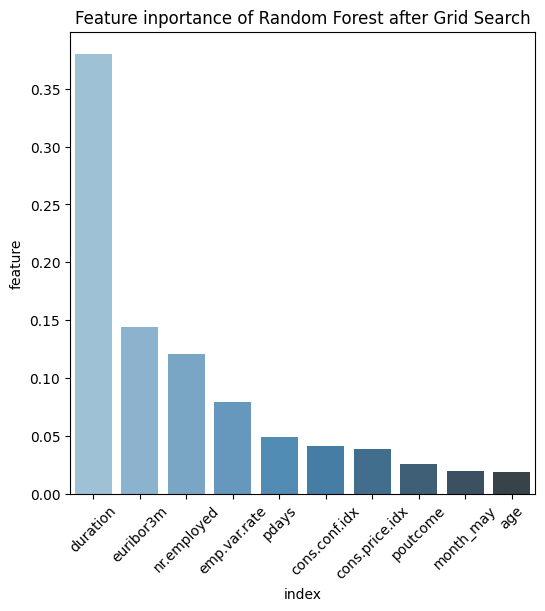

In [376]:
''' Build bar plot of feature importance of the best model '''
def build_feature_importance(X_train, y_train):
    
    models = RandomForestClassifier(criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3, n_estimators=70)
    models.fit(X_train, y_train)
    data2 = pd.DataFrame(models.feature_importances_, X_train.columns, columns=["feature"])
    data2 = data2.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[6,6])
    sns.barplot(x='index', y='feature', data=data2[:10], palette="Blues_d")
    plt.title('Feature inportance of Random Forest after Grid Search')
    plt.xticks(rotation=45)
    plt.show();
    
build_feature_importance(X_train, y_train)